# Autoencoder as Nonlinear PCA — Digits (TensorFlow / Keras)
An autoencoder trained on sklearn's Digits dataset (1,797 samples, 8×8 images) with a 2D bottleneck. The learned latent space is visualized and compared against standard PCA.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

## 1. Load & Preprocess Digits

In [6]:
digits = load_digits()
X      = digits.data.astype(np.float32)    # (1797, 64) — already flattened 8x8
y      = digits.target                     # (1797,)  — digit labels 0-9

# Scale to [0, 1]
scaler   = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train / test split — stratified to keep all 10 classes in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Total samples : {len(X)}')
print(f'Train         : {X_train.shape}')
print(f'Test          : {X_test.shape}')
print(f'Input dim     : {X_train.shape[1]}   (8x8 = 64 pixels)')

Total samples : 1797
Train         : (1437, 64)
Test          : (360, 64)
Input dim     : 64   (8x8 = 64 pixels)


## 2. Visualize Samples

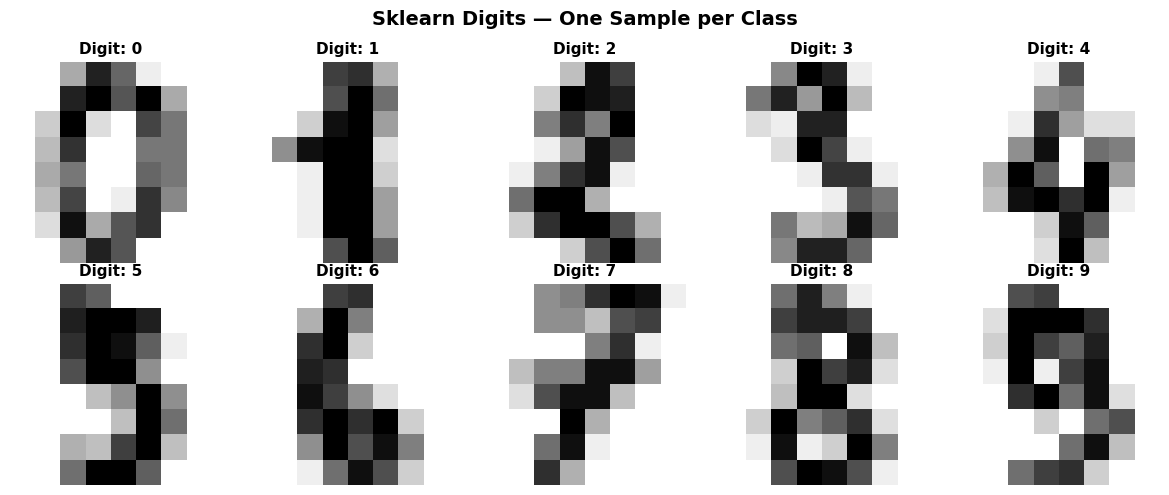

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = np.where(y == i)[0][0]
    ax.imshow(digits.images[idx], cmap='gray_r')
    ax.set_title(f'Digit: {i}', fontsize=11, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sklearn Digits — One Sample per Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Autoencoder Architecture

Built with the Keras functional API — encoder and decoder are separate named models, then composed into the full autoencoder.

```
Encoder: 64 -> 32 -> 16 -> 2   (bottleneck)
Decoder:  2 -> 16 -> 32 -> 64
```

In [19]:
LATENT_DIM = 2
INPUT_DIM  = 64

# --- Encoder ---
encoder_input = Input(shape=(INPUT_DIM,), name='encoder_input')
x = Dense(32, activation='relu', name='enc_dense1')(encoder_input)
x = Dense(16, activation='relu', name='enc_dense2')(x)
z = Dense(LATENT_DIM, activation=None, name='bottleneck')(x)   # no activation

encoder = Model(encoder_input, z, name='encoder')

# --- Decoder ---
decoder_input = keras.Input(shape=(LATENT_DIM,), name='decoder_input')
x = Dense(16, activation='relu', name='dec_dense1')(decoder_input)
x = Dense(32, activation='relu', name='dec_dense2')(x)
x_hat = Dense(INPUT_DIM, activation='sigmoid', name='decoder_output')(x)

decoder = Model(decoder_input, x_hat, name='decoder')

# --- Full Autoencoder ---
ae_input  = Input(shape=(INPUT_DIM,), name='ae_input')
ae_output = decoder(encoder(ae_input))
autoencoder = Model(ae_input, ae_output, name='autoencoder')

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse'
)

encoder.summary()
print()
decoder.summary()
print()
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense1 (Dense)              │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense2 (Dense)              │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,642 (10.32 KB)

 Trainable params: 2,642 (10.32 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense1 (Dense)              │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense2 (Dense)              │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 64)             │         2,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,704 (10.56 KB)

 Trainable params: 2,704 (10.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 2)              │         2,642 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64)             │         2,704 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,346 (20.88 KB)

 Trainable params: 5,346 (20.88 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Training

In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=5, factor=0.5, verbose=1
)

history = autoencoder.fit(
    X_train, X_train,              # input = target (unsupervised)
    epochs=200,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1707 - val_loss: 0.1123 - learning_rate: 0.0010
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0936 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0745 - val_loss: 0.0728 - learning_rate: 0.0010
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0705 - val_loss: 0.0677 - learning_rate: 0.0010
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0656 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0640 - val_loss: 0.0640 - learning_rate: 0.0010
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0622 - val_loss: 0.0624 - learning_rate: 0.0010
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0615 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0603 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 10/200
45/45 

## 5. Loss Curves

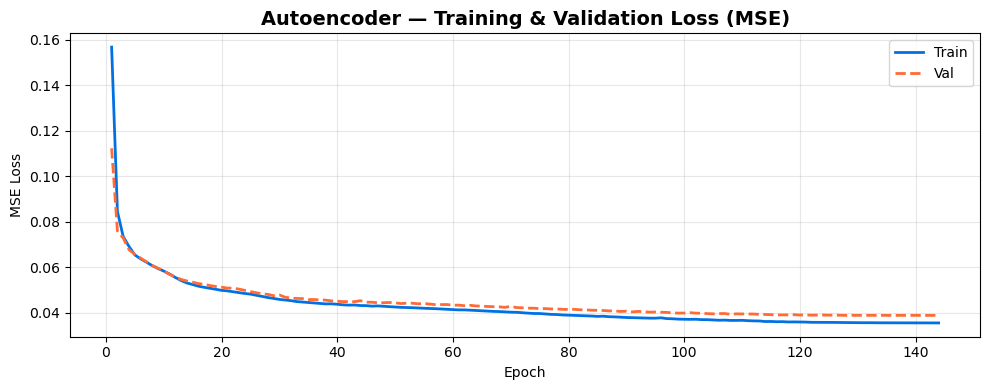

In [10]:
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
epochs_ran = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs_ran, train_loss, label='Train', color='#0071e3', linewidth=2)
plt.plot(epochs_ran, val_loss,   label='Val',   color='#ff6b35', linewidth=2, linestyle='--')
plt.title('Autoencoder — Training & Validation Loss (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Reconstruction Quality

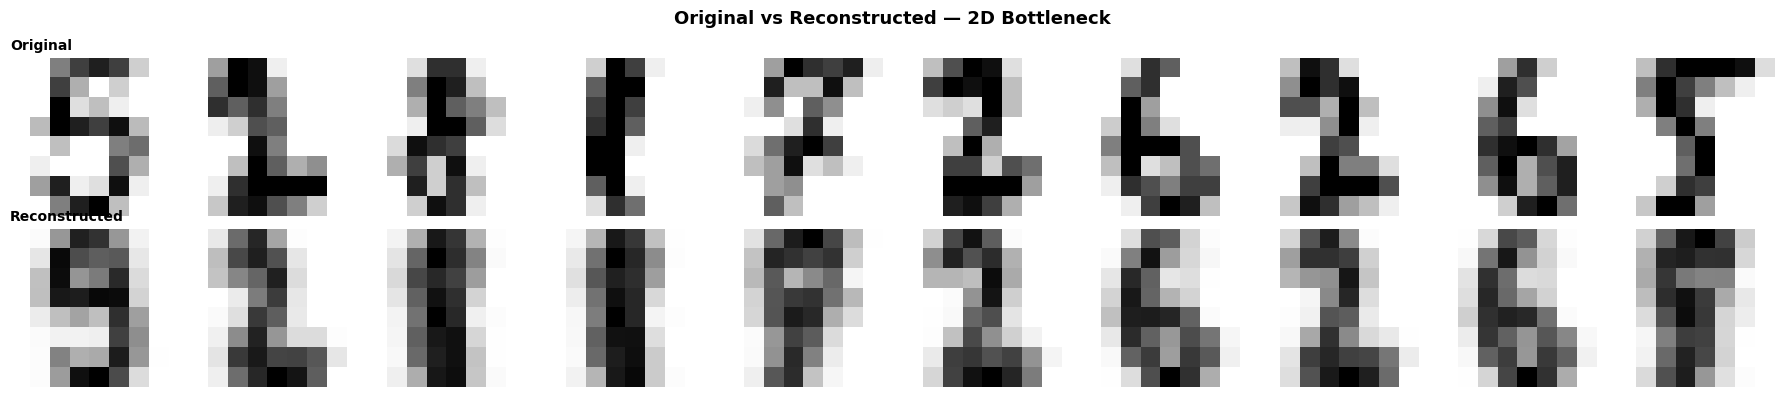

In [11]:
X_recon = autoencoder.predict(X_test, verbose=0)

n = 10
fig, axes = plt.subplots(2, n, figsize=(18, 4))

for i in range(n):
    axes[0, i].imshow(X_test[i].reshape(8, 8), cmap='gray_r')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original', fontsize=10, fontweight='bold', loc='left')

    axes[1, i].imshow(X_recon[i].reshape(8, 8), cmap='gray_r')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed', fontsize=10, fontweight='bold', loc='left')

plt.suptitle('Original vs Reconstructed — 2D Bottleneck', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. 2D Latent Space — Autoencoder

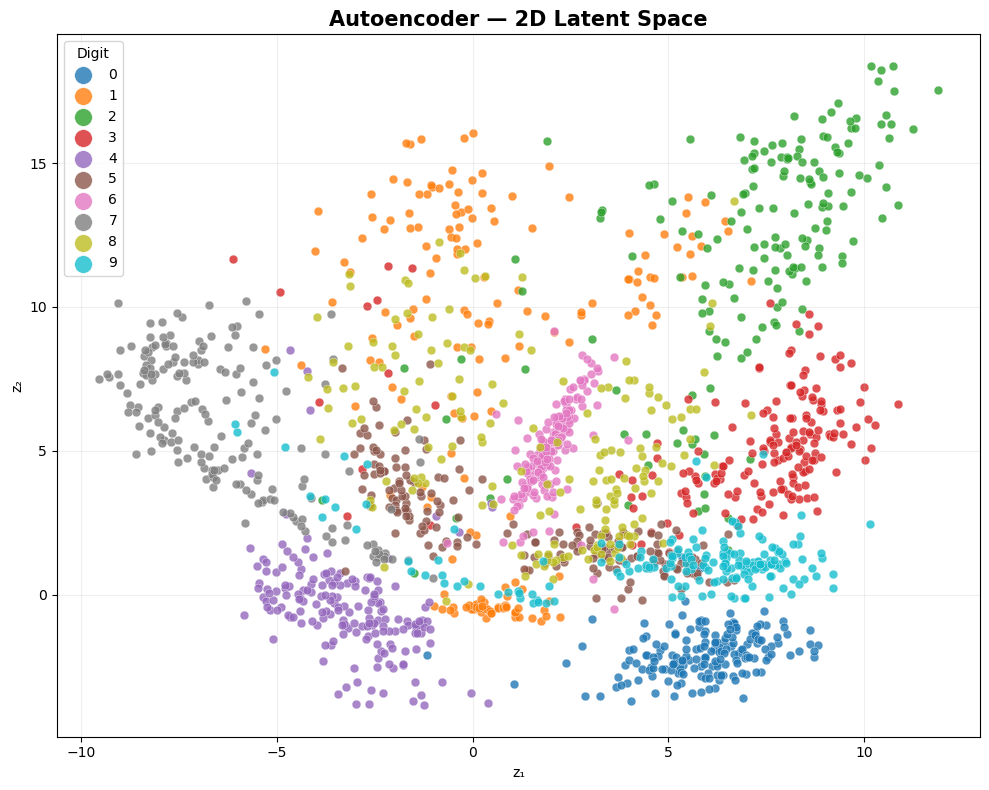

In [12]:
# Encode full dataset for visualization
Z_all  = encoder.predict(X_scaled, verbose=0)   # (1797, 2)
colors = cm.tab10(np.linspace(0, 1, 10))

plt.figure(figsize=(10, 8))
for digit in range(10):
    mask = y == digit
    plt.scatter(Z_all[mask, 0], Z_all[mask, 1],
                c=[colors[digit]], label=str(digit),
                s=40, alpha=0.8, edgecolors='white', linewidths=0.3)

plt.title('Autoencoder — 2D Latent Space', fontsize=15, fontweight='bold')
plt.xlabel('z\u2081')
plt.ylabel('z\u2082')
plt.legend(title='Digit', markerscale=2, fontsize=10, loc='best')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 8. PCA Baseline — 2D Projection

PCA explained variance: 28.34%


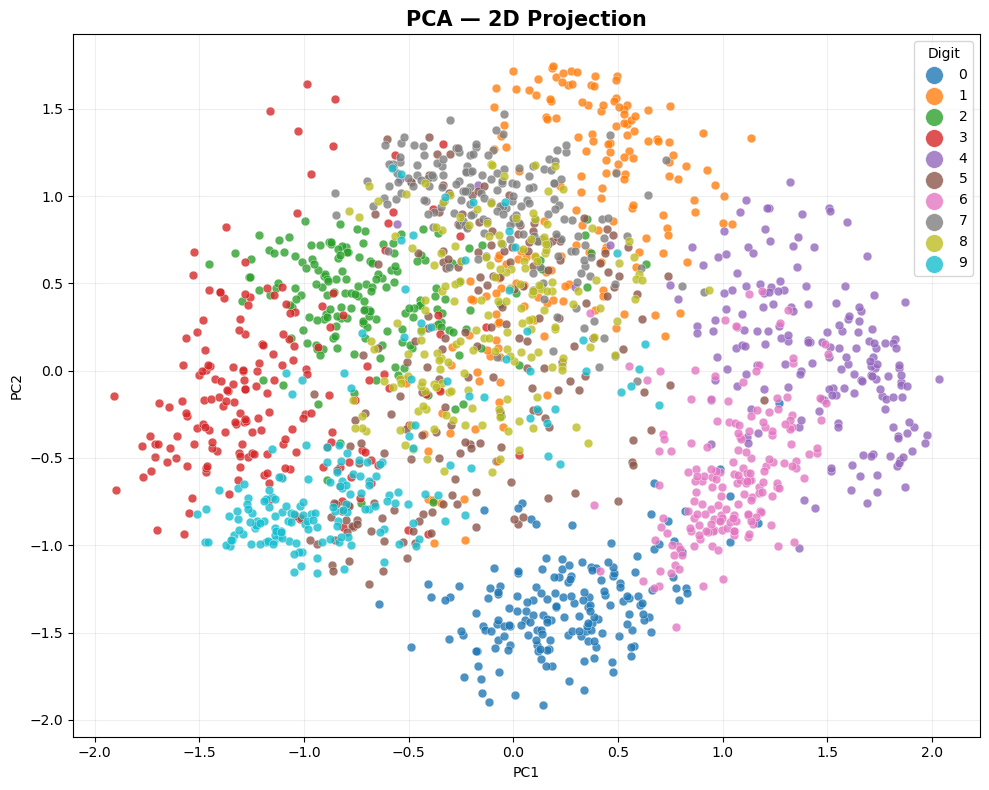

In [13]:
pca   = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f'PCA explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%')

plt.figure(figsize=(10, 8))
for digit in range(10):
    mask = y == digit
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=[colors[digit]], label=str(digit),
                s=40, alpha=0.8, edgecolors='white', linewidths=0.3)

plt.title('PCA — 2D Projection', fontsize=15, fontweight='bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Digit', markerscale=2, fontsize=10, loc='best')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 9. Side-by-Side Comparison — Autoencoder vs PCA

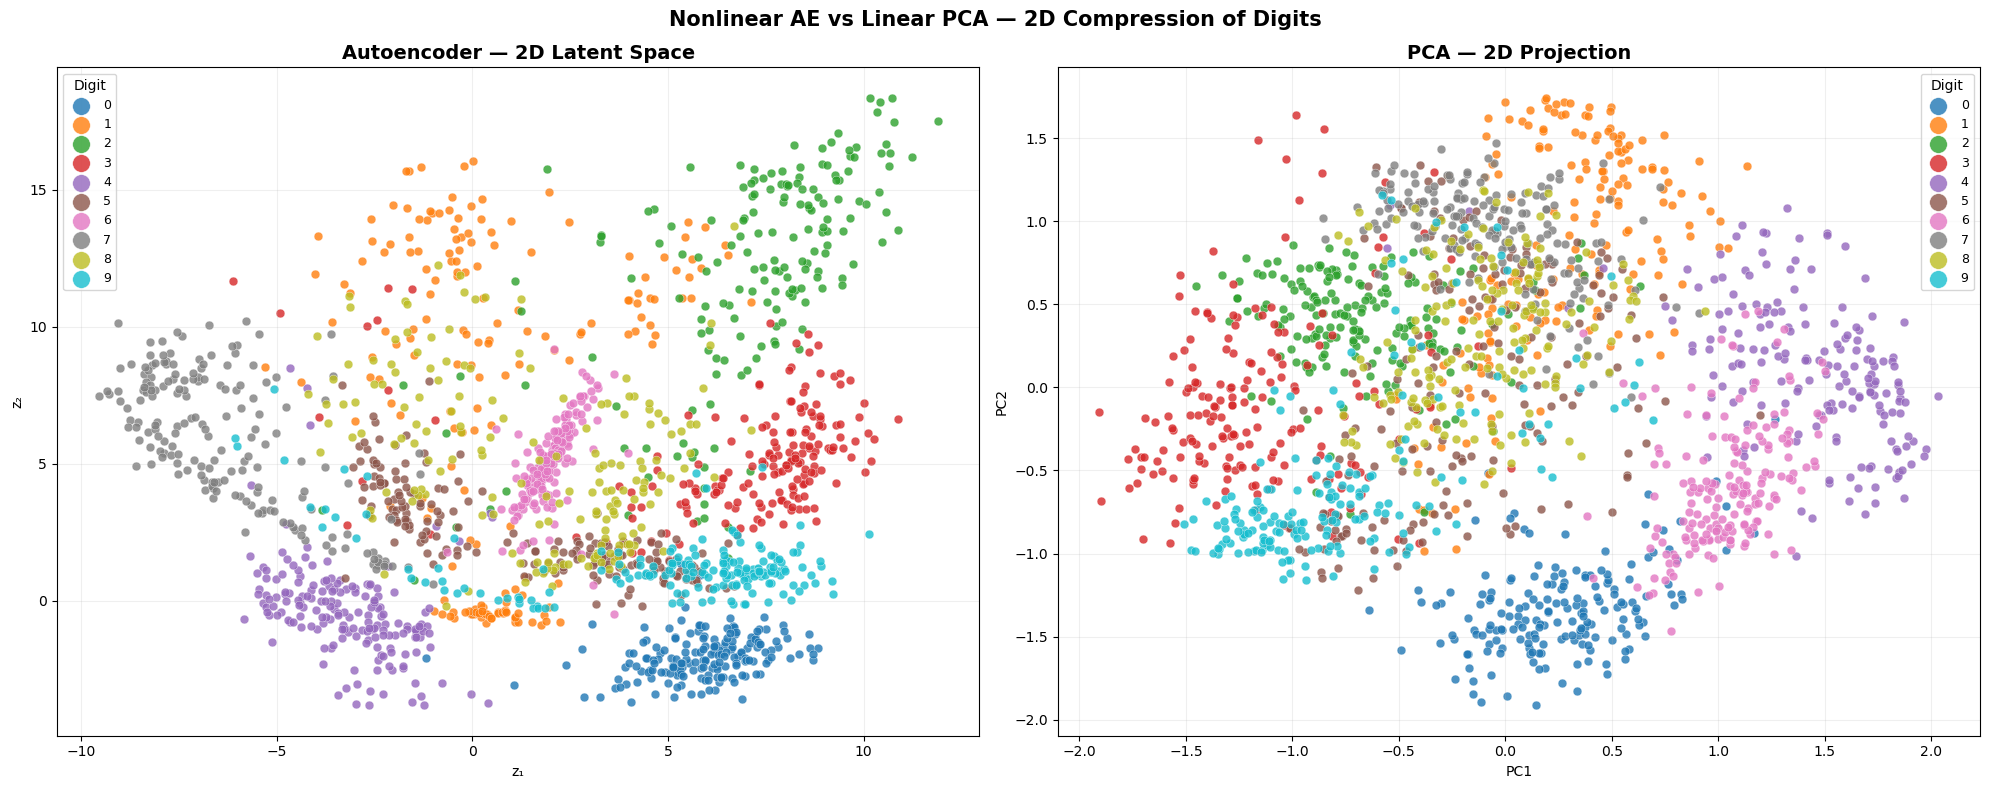

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for digit in range(10):
    mask = y == digit
    axes[0].scatter(Z_all[mask, 0], Z_all[mask, 1],
                    c=[colors[digit]], label=str(digit),
                    s=40, alpha=0.8, edgecolors='white', linewidths=0.3)
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    c=[colors[digit]], label=str(digit),
                    s=40, alpha=0.8, edgecolors='white', linewidths=0.3)

axes[0].set_title('Autoencoder — 2D Latent Space', fontsize=14, fontweight='bold')
axes[0].set_xlabel('z\u2081'); axes[0].set_ylabel('z\u2082')
axes[0].legend(title='Digit', markerscale=2, fontsize=9)
axes[0].grid(True, alpha=0.2)

axes[1].set_title('PCA — 2D Projection', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PC1'); axes[1].set_ylabel('PC2')
axes[1].legend(title='Digit', markerscale=2, fontsize=9)
axes[1].grid(True, alpha=0.2)

plt.suptitle('Nonlinear AE vs Linear PCA — 2D Compression of Digits',
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()